1. Importar las librerías

In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

2. Cargar los datos

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/data_evaluacion.csv')

print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

print(df.info())

| 39   | State-gov        | 77516   | Bachelors   | 13   | Never-married      | Adm-clerical      | Not-in-family   | White   | Male   | 2174   | 0   | 40   | United-States   | <=50K   |
|:-----|:-----------------|:--------|:------------|:-----|:-------------------|:------------------|:----------------|:--------|:-------|:-------|:----|:-----|:----------------|:--------|
| 50   | Self-emp-not-inc | 83311   | Bachelors   | 13   | Married-civ-spouse | Exec-managerial   | Husband         | White   | Male   | 0      | 0   | 13   | United-States   | <=50K   |
| 38   | Private          | 215646  | HS-grad     | 9    | Divorced           | Handlers-cleaners | Not-in-family   | White   | Male   | 0      | 0   | 40   | United-States   | <=50K   |
| 53   | Private          | 234721  | 11th        | 7    | Married-civ-spouse | Handlers-cleaners | Husband         | Black   | Male   | 0      | 0   | 40   | United-States   | <=50K   |
| 28   | Private          | 338409  | Bachelors   | 13   | Marrie

Renombrar las columnas para que sean más claras

In [5]:

df.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48841 entries, 0 to 48840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48841 non-null  int64 
 1   workclass       48841 non-null  object
 2   fnlwgt          48841 non-null  int64 
 3   education       48841 non-null  object
 4   education_num   48841 non-null  int64 
 5   marital_status  48841 non-null  object
 6   occupation      48841 non-null  object
 7   relationship    48841 non-null  object
 8   race            48841 non-null  object
 9   sex             48841 non-null  object
 10  capital_gain    48841 non-null  int64 
 11  capital_loss    48841 non-null  int64 
 12  hours_per_week  48841 non-null  int64 
 13  native_country  48841 non-null  object
 14  income          48841 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


4. Dividir los datos en conjuntos de entrenamiento y prueba

In [6]:


# Separa las características (X) y la variable objetivo (y)
X = df.drop('income', axis=1)
y = df['income']

# Convertir la variable objetivo a binario
y = y.apply(lambda x: 1 if x == '>50K' else 0)

# Identifica las columnas categóricas y numéricas
X_categorical = X.select_dtypes(include=['object'])
X_numeric = X.select_dtypes(include=['int64'])

# Convierte las columnas booleanas a valores numéricos
for col in X_categorical:
    if X_categorical[col].isin([True, False]).all():
        X_categorical[col] = X_categorical[col].astype(int)




5. Normalización

In [7]:

# Aplica one-hot encoding a las variables categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = encoder.fit_transform(X_categorical)

# Estandariza las variables numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combina las variables codificadas y numéricas
X_processed = pd.concat([pd.DataFrame(X_encoded, index=X.index), pd.DataFrame(X_numeric_scaled, index=X.index)], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

# Crea y entrena un modelo de regresión logística
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred_lr = model_lr.predict(X_test)


6. Gráficas

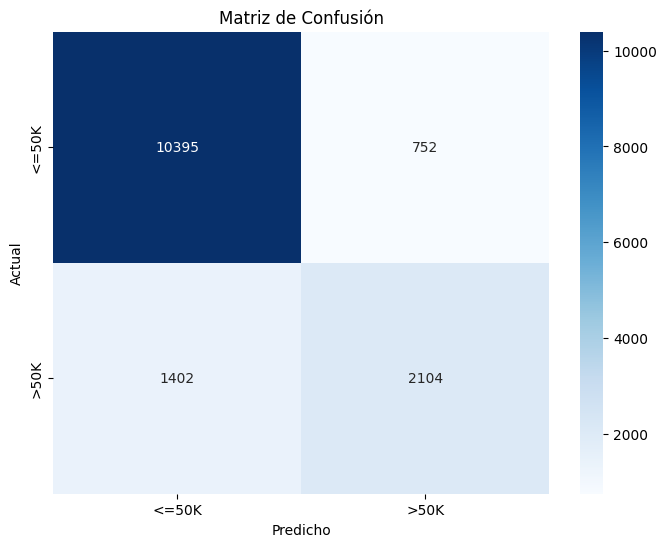

In [9]:
# Gráfica de la Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()


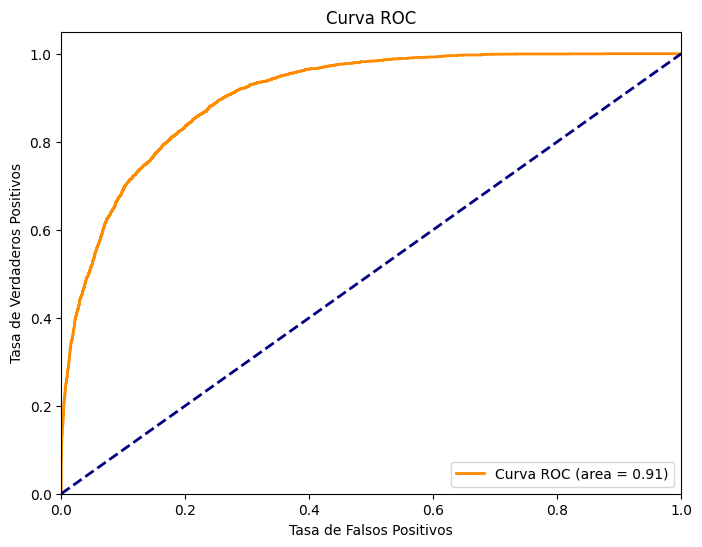

In [10]:
# Curva ROC
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

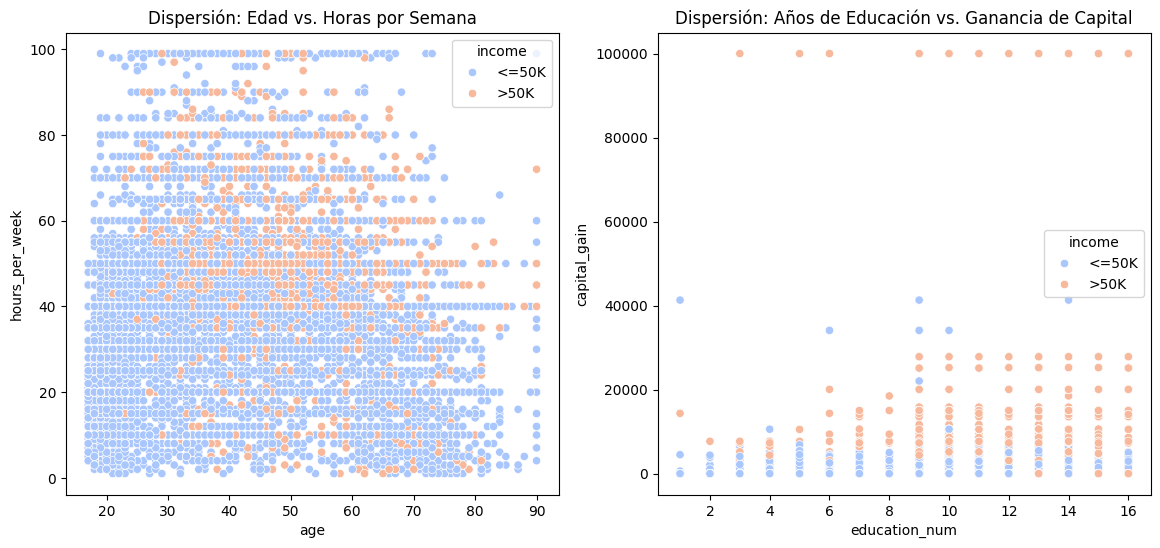

In [11]:
# Gráfica de Dispersión para algunas características
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='age', y='hours_per_week', hue='income', palette='coolwarm')
plt.title('Dispersión: Edad vs. Horas por Semana')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='education_num', y='capital_gain', hue='income', palette='coolwarm')
plt.title('Dispersión: Años de Educación vs. Ganancia de Capital')
plt.show()


7. Resultados

In [12]:
# Calcula y muestra la matriz de confusión y la precisión
print("Regresión Logística:")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_lr))
print("Precisión:", accuracy_score(y_test, y_pred_lr))
print("\n")
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred_lr))


Regresión Logística:
Matriz de Confusión:
[[10395   752]
 [ 1402  2104]]
Precisión: 0.8529993857913055


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     11147
           1       0.74      0.60      0.66      3506

    accuracy                           0.85     14653
   macro avg       0.81      0.77      0.78     14653
weighted avg       0.85      0.85      0.85     14653



In [13]:
# Evaluar el rendimiento en el conjunto de entrenamiento
y_train_pred_lr = model_lr.predict(X_train)
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)

# Evaluar el rendimiento en el conjunto de prueba
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Regresión Logística - Precisión en el conjunto de entrenamiento:", train_accuracy_lr)
print("Regresión Logística - Precisión en el conjunto de prueba:", test_accuracy_lr)

# Determinar si hay overfitting o underfitting
if train_accuracy_lr > test_accuracy_lr + 0.05:
    print("El modelo de regresión logística está sobreajustado (overfitting).")
elif train_accuracy_lr < 0.7 and test_accuracy_lr < 0.7:
    print("El modelo de regresión logística está subajustado (underfitting).")
else:
    print("El modelo de regresión logística tiene un buen ajuste.")


Regresión Logística - Precisión en el conjunto de entrenamiento: 0.853047853047853
Regresión Logística - Precisión en el conjunto de prueba: 0.8529993857913055
El modelo de regresión logística tiene un buen ajuste.


Conclusion:

El modelo de regresión logística muestra una precisión general del 85%, siendo más preciso en la predicción de la clase 0 (88%) que en la clase 1 (74%). Aunque el modelo acierta en la mayoría de los casos, tiene un rendimiento relativamente bajo en la identificación de la clase 1